In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
OriginalData_DIR='/content/drive/MyDrive/FiverrOrders/22_01_05Munazza/labwork12April'
NewData_DIR='/content/drive/MyDrive/FiverrOrders/22_01_05Munazza'
MASK_DIR=OriginalData_DIR+"/masks"
IMAGES_DIR=OriginalData_DIR+"/images"
RESULTANTDATASETFOLDER=OriginalData_DIR+"/dataset"
R_Images=RESULTANTDATASETFOLDER+"/images/"
R_Masks=RESULTANTDATASETFOLDER+"/masks/"
AlignedData=NewData_DIR+"/AlignedData"
Aligned_Images=AlignedData+"/images/"
Aligned_Masks=AlignedData+"/masks/"
imagesNames=['Pre-process.tif','060063w.tif','060102w.tif','060104w.tif']

##import lib


In [2]:
import os
import math
import imgaug.augmenters as iaa
import imgaug as ia
import json
import shutil
from PIL import Image, ImageDraw
from pathlib import Path
import collections
from collections import defaultdict
from pycocotools import mask as MASK
import numpy as np
import skimage
from skimage.filters import threshold_mean
from skimage.color import rgb2gray, gray2rgb
from skimage import measure
import skimage.io
import cv2
from matplotlib import pyplot as plt
import random

from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours


#Prepare

In [3]:
def readmasks(path,size,crop=None):
  mask=plt.imread(path)
  if len(mask.shape)<3:
    mask=cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
  if crop!=None:
    mask = mask[crop[0]:crop[1],crop[2]:crop[3],:]
  mask = cv2.resize(mask, size) 
  # mask = mask>0
  #mask=mask[:,:,0:1]
  return mask

  ##rotation code
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

def getrotatedimage(image,rotation):
  image_orig = np.copy(image)
  image_height, image_width = image_orig.shape[0:2]
  image_rotated = rotate_image(image_orig, rotation)
  image_rotated_cropped = crop_around_center(
            image_rotated,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(rotation)
            )
        )
  return image_rotated_cropped

###Define Visualizer

In [4]:
import colorsys
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()
def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")



## Visualize All Masks

In [5]:
images=[_ for _ in imagesNames]
masks=[_ for _ in imagesNames]
windowSizes=[_ for _ in imagesNames]

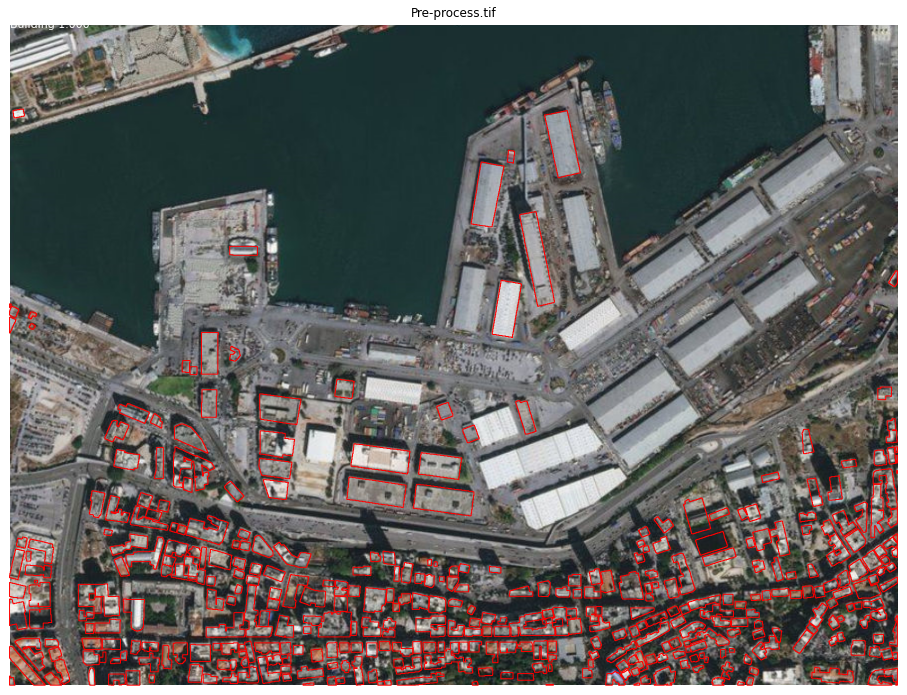

(2664, 3585, 4)
(2664, 3585, 3)


In [6]:
i=0
imageName=imagesNames[i]
img =plt.imread(IMAGES_DIR+'/'+imageName)

mask =readmasks(MASK_DIR+'/'+imageName,(img.shape[1], img.shape[0]))
  
display_instances(img, np.array([[0,0,img.shape[0],img.shape[1]]]),mask[:,:,0:1]>0, np.array([1]), 
                            ['BG','Building'], np.array([1]), 
                            title=imageName,show_mask=False,show_bbox=False)
plt.show()
images[i]=img
masks[i]=mask.astype(np.uint8)
print(images[i].shape)
print(masks[i].shape)
windowSizes[i]=500

In [7]:
i=1
imageName=imagesNames[i]
img =plt.imread(IMAGES_DIR+'/'+imageName)


## align both
img = img[5:-20,40:,:] 
mask =readmasks(MASK_DIR+'/'+imageName,(img.shape[1], img.shape[0]),(40,-1,7,-30))


## make squared
# img = img[:,300:-105,:]
# mask = mask[:,300:-105,:]  
display_instances(img, np.array([[0,0,img.shape[0],img.shape[1]]]),mask[:,:,0:1]>0, np.array([1]), 
                            ['BG','Building'], np.array([1]), 
                            title=imageName,show_mask=False,show_bbox=False)
plt.show()

images[i]=img
masks[i]=mask.astype(np.uint8)

print(images[i].shape)
print(masks[i].shape)
windowSizes[i]=300

Output hidden; open in https://colab.research.google.com to view.

In [8]:
i=2
imageName=imagesNames[i]
img =plt.imread(IMAGES_DIR+'/'+imageName)

## align both
img = img[15:-20,40:,:] 
mask =readmasks(MASK_DIR+'/'+imageName,(img.shape[1], img.shape[0]),(40,-1,10,-30))
  

# ## make squared
# img = img[:,:-425,:]
# mask = mask[:,:-425,:]
display_instances(img, np.array([[0,0,img.shape[0],img.shape[1]]]),mask[:,:,0:1]>0, np.array([1]), 
                            ['BG','Building'], np.array([1]), 
                            title=imageName,show_mask=False,show_bbox=False)
plt.show()

images[i]=img
masks[i]=mask.astype(np.uint8)

print(images[i].shape)
print(masks[i].shape)
windowSizes[i]=300

Output hidden; open in https://colab.research.google.com to view.

In [9]:
i=3
imageName=imagesNames[i]
img =plt.imread(IMAGES_DIR+'/'+imageName)

## align both
img = img[15:-20,40:,:] 
mask =readmasks(MASK_DIR+'/'+imageName,(img.shape[1], img.shape[0]),(40,-1,10,-30))




# ## make squared
# img = img[:,425:,:]
# mask = mask[:,425:,:]

display_instances(img, np.array([[0,0,img.shape[0],img.shape[1]]]),mask[:,:,0:1]>0, np.array([1]), 
                            ['BG','Building'], np.array([1]), 
                            title=imageName,show_mask=False,show_bbox=False)
plt.show()

images[i]=img
masks[i]=mask.astype(np.uint8)
print(images[i].shape)
print(masks[i].shape)
windowSizes[i]=300

Output hidden; open in https://colab.research.google.com to view.

#Generate Dataset


In [15]:
if os.path.isdir(AlignedData):
  shutil.rmtree(AlignedData)
os.mkdir(AlignedData)
if not os.path.isdir(Aligned_Images):
  os.mkdir(Aligned_Images)
if not os.path.isdir(Aligned_Masks):
  os.mkdir(Aligned_Masks)
for img, mask,name in zip(images,masks,imagesNames):
    img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(Aligned_Images+"/"+name,img)
    cv2.imwrite(Aligned_Masks+"/"+name,mask)
